In [1]:
import matplotlib.pyplot as plt

from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from Header.preprocessing import *
from Header.metric import *
from Header.model_select import *

# Read file(.npy)

In [2]:
# 4 class
# file_lst = ['./Dataset/Inner_Defect.npy', './Dataset/Inner_Break.npy','./Dataset/Outer_Break.npy','./Dataset/Normal.npy']
# name_lst = ['inner_defect', 'inner_break', 'outer_break', 'normal']

# # 5 class
file_lst = ['./Dataset/Inner_Defect.npy', './Dataset/Inner_Break.npy','./Dataset/Outer_Defect.npy','./Dataset/Outer_Break.npy','./Dataset/Normal.npy']
name_lst = ['inner_defect', 'inner_break','outer_defect', 'outer_break', 'normal']

# 7 class
# file_lst = ['./Dataset/Inner_Defect.npy', './Dataset/Cage_Break.npy', './Dataset/Inner_Break.npy','./Dataset/Ball.npy','./Dataset/Outer_Break.npy','./Dataset/Outer_Defect.npy','./Dataset/Normal.npy']
# name_lst = ['inner_defect', 'cage_break', 'inner_break', 'ball', 'outer_break', 'outer_defect', 'normal']

mag_x, time_x, Y = read_file(file_lst, name_lst, 50, 256, outlier_detect_mode = 2, lower = 5, upper = 95, percentage = 0.1)

X.shape = (3600, 128)
Y.shape = (3600,)


# Train test split

In [3]:
x_train, x_test, y_train, y_test = train_test_split(mag_x, Y, test_size = 0.25, random_state = 12)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2700, 128) (2700,)
(900, 128) (900,)


# Tuning Random Forest parameter

In [5]:
# Tuning n_estimators
alg = "RandomForestClassifier(n_estimators = j, class_weight = 'balanced')"
param = {"n_estimators": np.arange(20, 250, 20)}
tuning_param(alg = alg, parameter = param, name_lst = name_lst, x_train = x_train,
             y_train = y_train, x_test = x_test, y_test = y_test, test_time = 10)

n_estimators report:
The most approriate value is 140 (by Accuracy).


min_sample_split report:
The most approriate value is 4 (by Accuracy).


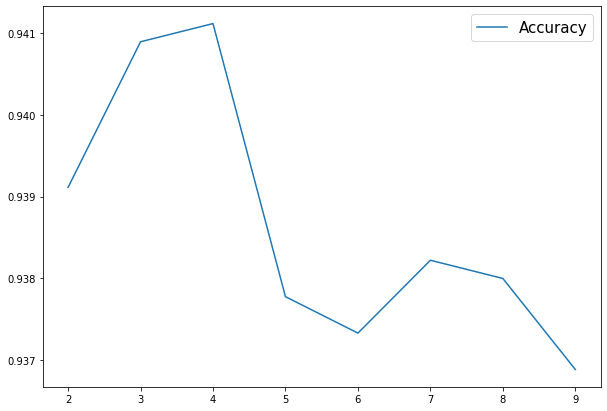

In [8]:
# Tuning min_samples_split
alg = "RandomForestClassifier(n_estimators = 100, min_samples_split = j, class_weight = 'balanced')"
param = {"min_sample_split": np.arange(2, 10, 1)}
tuning_param(alg = alg, parameter = param, name_lst = name_lst, x_train = x_train,
             y_train = y_train, x_test = x_test, y_test = y_test, test_time = 10)

min_sample_leaf report:
The most approriate value is 1 (by Accuracy).


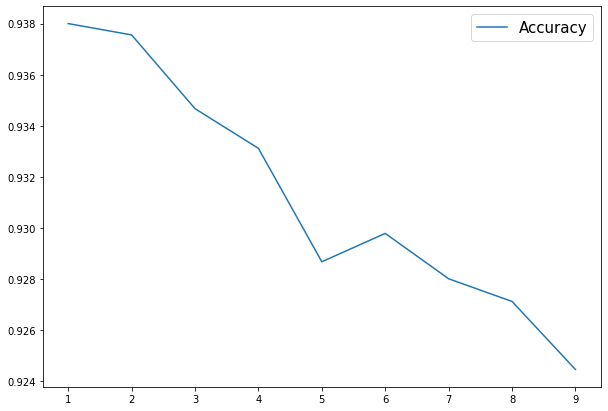

In [4]:
# Tuning min_samples_leaf
alg = "RandomForestClassifier(n_estimators = 100, min_samples_split = 4,min_samples_leaf = j, class_weight = 'balanced')"
param = {"min_sample_leaf": np.arange(1, 10, 1)}
tuning_param(alg = alg, parameter = param, name_lst = name_lst, x_train = x_train, 
             y_train = y_train, x_test = x_test, y_test = y_test, test_time = 5)

min_impurity_decrease report:
The most approriate value is 0.0 (by Accuracy).


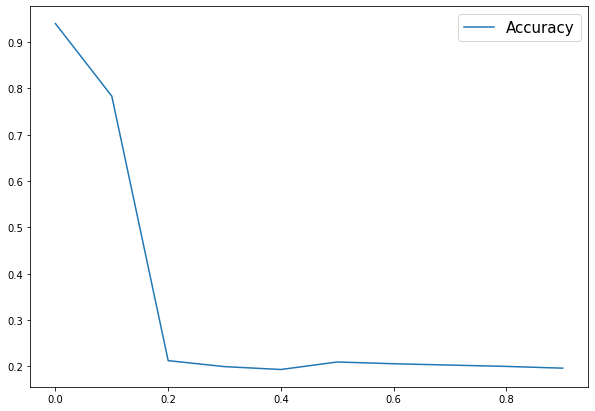

In [9]:
# Tuning min_impurity_decrease
alg = "RandomForestClassifier(n_estimators = 100, min_samples_split = 4,min_samples_leaf = 1,\
                              class_weight = 'balanced', min_impurity_decrease = j)"
param = {"min_impurity_decrease": np.arange(0, 1, 0.1)}
tuning_param(alg = alg, parameter = param, name_lst = name_lst, x_train = x_train, 
             y_train = y_train, x_test = x_test, y_test = y_test, test_time = 10)

ccp_alpha report:
The most approriate value is 0.0 (by Accuracy).


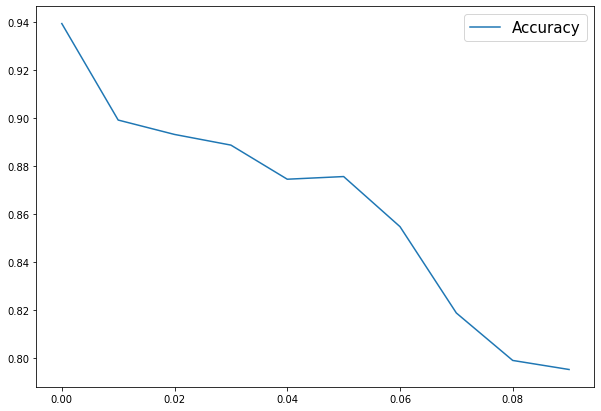

In [11]:
# Tuning ccp_alphg
alg = "RandomForestClassifier(n_estimators = 100, min_samples_split = 4,min_samples_leaf = 1,\
                              class_weight = 'balanced', min_impurity_decrease = 0,\
                              ccp_alpha = j)"
param = {"ccp_alpha": np.arange(0, 0.1, 0.01)}
tuning_param(alg = alg, parameter = param, name_lst = name_lst, x_train = x_train, 
             y_train = y_train, x_test = x_test, y_test = y_test, test_time = 10)

# Final parameter

In [4]:
# Big model know which feature is important.
rf = RandomForestClassifier(n_estimators = 150, min_samples_split = 4,min_samples_leaf = 1,
                            class_weight = 'balanced', min_impurity_decrease = 0,
                            ccp_alpha = 0)
rf.fit(x_train, y_train)

# modelreport(rf, x_train, y_train, target_names = name_lst, mtype='ML')
acc, auc = modelreport(rf, x_test, y_test, target_names = name_lst, mtype='ML')

Accuracy : 0.9433
              precision    recall  f1-score   support

inner_defect       1.00      1.00      1.00       168
 inner_break       1.00      0.99      1.00       155
outer_defect       0.91      0.83      0.87       196
 outer_break       0.98      0.98      0.98       183
      normal       0.85      0.93      0.89       198

    accuracy                           0.94       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.94      0.94      0.94       900

AUC Score: 0.993211


# Feature selection

In [5]:
# Get feature importance
rf = load('./model/rf_big.model') 
final_importance, mask = GetFeatureImportanceAndMask(rf, x_train, y_train, percentage = 0.8)
np.save('./feature_importance_mask/mask.npy', mask)

In [9]:
# We should put this small model on pynq.
rf = RandomForestClassifier(n_estimators = 150, min_samples_split = 4,min_samples_leaf = 1,
                             class_weight = 'balanced', min_impurity_decrease = 0,
                             ccp_alpha = 0)


rf.fit(x_train_fe, y_train)

# modelreport(rf2, x_train_fe, y_train, target_names = name_lst, mtype='ML')
modelreport(rf, x_test_fe, y_test, target_names = name_lst, mtype='ML')

Accuracy : 0.9522
              precision    recall  f1-score   support

inner_defect       1.00      0.99      1.00       168
 inner_break       0.99      0.99      0.99       155
outer_defect       0.94      0.85      0.89       196
 outer_break       0.98      0.98      0.98       183
      normal       0.88      0.96      0.92       198

    accuracy                           0.95       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.95      0.95      0.95       900

AUC Score: 0.994589


(0.9522222222222222, 0.9945894682668869)

In [4]:
mask = np.load('./feature_importance_mask/mask.npy')
x_train_fe = x_train[:, mask[:36]]
x_test_fe = x_test[:, mask[:36]]

n_estimators report:
The most approriate value is 50 (by Accuracy).


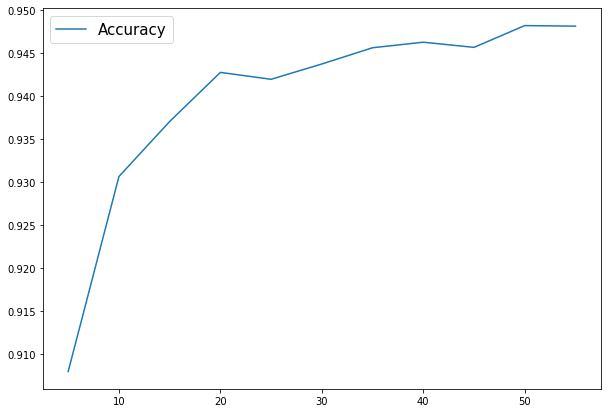

RandomForestClassifier(bootstrap=True, ccp_alpha=0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=55,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [5]:
# Tuning n_estimators
alg = "RandomForestClassifier(n_estimators = j, min_samples_split = 4,min_samples_leaf = 1,\
                              class_weight = 'balanced', min_impurity_decrease = 0,\
                              ccp_alpha = 0)"
param = {"n_estimators": np.arange(5, 60, 5)}
tuning_param(alg = alg, parameter = param, name_lst = name_lst, x_train = x_train_fe,
             y_train = y_train, x_test = x_test_fe, y_test = y_test, test_time = 50)

In [7]:
# Tuning min_samples_split
alg = "RandomForestClassifier(n_estimators = 50, min_samples_split = j, class_weight = 'balanced')"
param = {"min_sample_split": np.arange(2, 10, 1)}
tuning_param(alg = alg, parameter = param, name_lst = name_lst, x_train = x_train,
             y_train = y_train, x_test = x_test, y_test = y_test, test_time = 50)

min_sample_split report:
The most approriate value is 6 (by Accuracy).


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

min_sample_leaf report:
The most approriate value is 1 (by Accuracy).


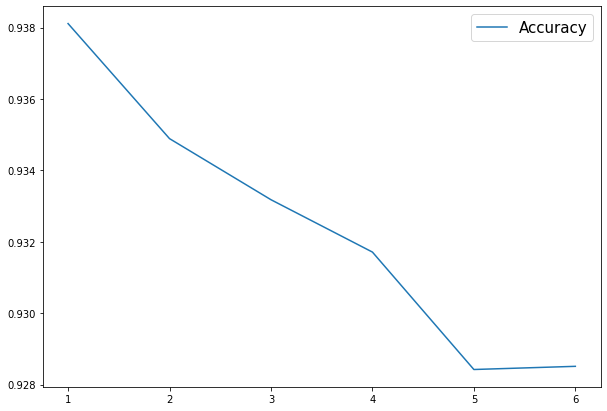

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [9]:
# Tuning min_samples_leaf
alg = "RandomForestClassifier(n_estimators = 50, min_samples_split = 6,min_samples_leaf = j, class_weight = 'balanced')"
param = {"min_sample_leaf": np.arange(1, 7, 1)}
tuning_param(alg = alg, parameter = param, name_lst = name_lst, x_train = x_train, 
             y_train = y_train, x_test = x_test, y_test = y_test, test_time = 50)

min_impurity_decrease report:
The most approriate value is 0.0 (by Accuracy).


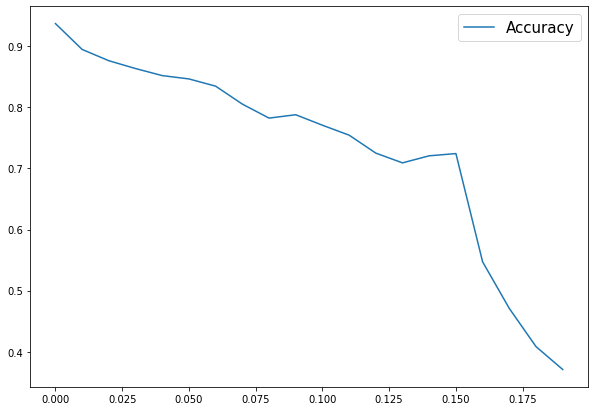

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.19, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
# Tuning min_impurity_decrease
alg = "RandomForestClassifier(n_estimators = 50, min_samples_split = 6,min_samples_leaf = 1,\
                              class_weight = 'balanced', min_impurity_decrease = j)"
param = {"min_impurity_decrease": np.arange(0, 0.2, 0.01)}
tuning_param(alg = alg, parameter = param, name_lst = name_lst, x_train = x_train, 
             y_train = y_train, x_test = x_test, y_test = y_test, test_time = 20)

ccp_alpha report:
The most approriate value is 0.0 (by Accuracy).


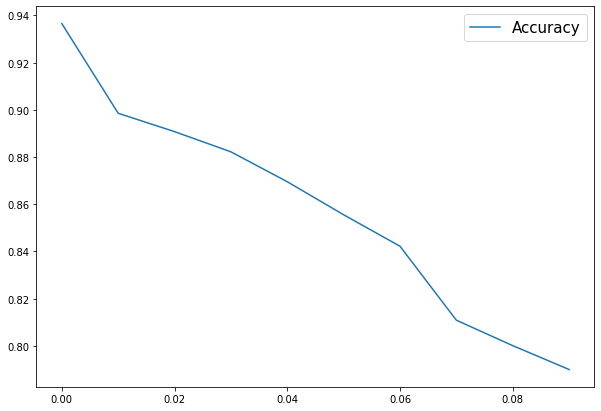

RandomForestClassifier(bootstrap=True, ccp_alpha=0.09, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
# Tuning ccp_alphg
alg = "RandomForestClassifier(n_estimators = 50, min_samples_split = 6,min_samples_leaf = 1,\
                              class_weight = 'balanced', min_impurity_decrease = 0,\
                              ccp_alpha = j)"
param = {"ccp_alpha": np.arange(0, 0.1, 0.01)}
tuning_param(alg = alg, parameter = param, name_lst = name_lst, x_train = x_train, 
             y_train = y_train, x_test = x_test, y_test = y_test, test_time = 10)

In [24]:
rf3 = RandomForestClassifier(n_estimators = 35, min_samples_split = 6,min_samples_leaf = 1,
                             class_weight = 'balanced', min_impurity_decrease = 0,
                             ccp_alpha = 0)

rf3.fit(x_train_fe, y_train)

modelreport(rf3, x_test_fe, y_test, target_names = name_lst, mtype='ML')
# alg = "RandomForestClassifier(n_estimators = j, min_samples_split = 6,min_samples_leaf = 1,\
#                               class_weight = 'balanced', min_impurity_decrease = 0,\
#                               ccp_alpha = 0)"

# param = {"n_estimators": np.arange(30, 41, 1)}
# tuning_param(alg = alg, parameter = param, name_lst = name_lst, x_train = x_train, 
#              y_train = y_train, x_test = x_test, y_test = y_test, test_time = 20)

Accuracy : 0.9489
              precision    recall  f1-score   support

inner_defect       1.00      1.00      1.00       168
 inner_break       1.00      0.99      1.00       155
outer_defect       0.93      0.83      0.88       196
 outer_break       0.98      0.99      0.99       183
      normal       0.86      0.95      0.90       198

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900

AUC Score: 0.993990


(0.9488888888888889, 0.9939896725680524)

In [28]:
dump(rf3, './model/rf_small.model')

['./model/rf_small.model']

# Save model

In [10]:
dump(rf, './model/rf_big.model')
# rf3 = joblib.load('lr.model')

['./model/rf_big.model']

# 輸出樹的架構(in txt file)

In [ ]:
from sklearn.tree import export_text

for i in range(len(rf2.estimators_)):
    r = export_text(rf2.estimators_[i], ['['+str(i)+']' for i in range(80)], max_depth = 100)
    with open("./Tree/tree{}.txt".format(i),"w") as f:
        f.write(r)

# 以下是做圖或不相干的東東

# Plot time domain and frequency domain data

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(time_x[1], label = 'time')
plt.legend(loc=1,prop={'size': 15})
plt.show()

plt.figure(figsize = (10, 5))
plt.bar(x = np.arange(mag_x[1].shape[0]), height = mag_x[1], width = 0.7, label = 'freq')
plt.legend(loc=1,prop={'size': 15})
plt.show()

In [ ]:
# 這裡不用管
mix = []
for i in range(Y.shape[0]):
    tmp = []
    for j in range(mag_y.shape[1]):
        tmp.append(np.array([mag_y[i][j], freq_y[i][j], time_y[i][j], mag_z[i][j], freq_z[i][j], time_z[i][j]]))
    mix.append(np.array(tmp))

mix = np.array(mix)
print(mix.shape)

# np.save('./Train&Test/x(xyz_axis_freq).npy', mix)
# np.save('./Train&Test/label.npy', y)

In [ ]:
# 繪圖用，也不用管
wnd = 256
size = 15
t = data['ball'][0][:wnd]

plt.rcParams["figure.figsize"] = (20,6)

plt.plot(t, label = 'time')
plt.plot(np.abs(hilbert(t)))
plt.legend(loc=2,prop={'size':size})
plt.show()

ft = np.fft.fft(t)[:wnd//2]
freq_x = np.abs(ft.real)
idx = np.argsort(freq_x)
mag_x = np.abs(ft)[idx]
h = np.abs(hilbert(np.abs(ft)))

plt.bar(np.arange(127), mag_x[:127][::-1], width=0.2, label = 'freq')
plt.legend(loc=2,prop={'size':size})
plt.show()
plt.bar(np.arange(127), h[:127], width=0.2, label = 'envelope')
plt.legend(loc=2,prop={'size':size})
plt.show()

# analytic_signal = hilbert(data['outer_break'][0][:256])
# amplitude_envelope = np.abs(analytic_signal)

# plt.plot(amplitude_envelope, label = 'envelope')
# plt.legend()
# plt.show()

# 繪製混淆矩陣

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.yticks(fontsize=25)
    plt.xticks(tick_marks, classes, rotation=45, fontsize=25)
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=30)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

rf = joblib.load('rf_big.model')
y_predict = rf.predict(x_test)
y_true = y_test

# target_names = ['normal_x', 'inner_break_x', 'outer_defect_x', 'ball_x', 'outer_break_x']
# target_names = ['normal', 'outer_break', 'inner_defect', 'inner_break', 'cagebreak', 'ball', 'outer_defect']
target_names = ['normal', 'outer rings break', 'outer rings defect', 'inner rings break', 'inner rings defect', 'ball break', 'cage break']
# y_predict = np.argmax(y_predict, axis=1)
# y_true = np.argmax(y_test, axis=1)

plt.figure(figsize=(12, 12))
cm = confusion_matrix(y_true, y_predict)
# tmp = [[1432,    1,    0,    1,    5,    0,    3],
#        [   0, 1038,    0,   23,    0,    0,    0],
#        [   2,    0, 1581,    8,    5,    1,    3],
#        [   0,   16,    6, 1782,    1,    1,    4],
#        [   6,    0,   14,    0, 1531,    0,    4],
#        [   0,    0,    0,    0,    0, 1424,    0],
#        [   5,    0,    0,    4,    5,    0, 1532]]
# cm = np.array(tmp, dtype=float)
plot_confusion_matrix(cm, classes=target_names,normalize=True,
                    title='confusion matrix')
# plt.imshow(cnf_matrix, cmap=plt.cm.Blues)
plt.show()

# model.save('./Model/Simple_conversion_x.h5')

# 繪製調參圖表

In [ ]:
acc_lst = []
auc_lst = []
for i in range(60, 128):
    rf_test = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=15, 
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=8, 
                            random_state=None, verbose=0, warm_start=False, class_weight='balanced', 
                            ccp_alpha=0.0, max_samples=None)
    idx = np.argsort(rf.feature_importances_)[::-1][:i]
    x_train_fe = x_train[:, idx]
    y_train_fe = y_train
    x_test_fe = x_test[:, idx]
    y_test_fe = y_test
    rf_test.fit(x_train_fe, y_train)
    acc, auc = modelreport(rf_test, x_test_fe, y_test, target_names = name_lst, mtype='ML')
    acc_lst.append(acc)
    auc_lst.append(auc)

In [ ]:
size = 20
plt.rcParams["figure.figsize"] = (20,10)
plt.tick_params(labelsize=20)
plt.plot(np.arange(60, 128), acc_lst, label = 'Accuracy')
plt.plot(np.arange(60, 128), auc_lst, label = 'Auroc')
plt.legend(loc=4,prop={'size':size})
plt.show()